# Comparison of different methods for changepoint estimation

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, dsc, mr-ash, regression-methods]
- slug: changepoint-estimation-adaptive-splines

### About

Here, we consider a class of non-parametric regression, particularly

$y_i = \mu_i + e_i$ with $i = 1, \cdots, n,$

where the goal is to estimate the underlying mean $\mu_i$ under the assumption that it varies in a spatially structured way. For a comprehensive discussion of this problem, see [Tibshirani, 2014](https://doi.org/10.1214/13-AOS1189). One very simple way to capture spatial structure in $\mu$ is to model it as a (sparse) linear combination of step functions:

$\mathbf{\mu} = \mathbf{X}\mathbf{b}$

where the $j$th column of $\mathbf{X}$ is the step function with a step at $j$; that is $x_{ij} = 0$ for $i \lt j$ and $1$ for $i \ge j$. The $j$th element of $\mathbf{b}$ therefore determines the change in the mean $\mu_j - \mu_{j + 1}$, and an assumption that $\mathbf{b}$ is sparse encapsulates an assumption that $\mu$ is spatially structured (indeed, piecewise constant). This very simple approach is essentially 0th-order trend filtering. Higher-order trend filtering can be similarly implemented using different basis function $\mathbf{X}$. For any order $k$, the basis function can be defined as,

$
  x_{ij} = \begin{cases}
      i^{j - 1} / n^{j - 1}, & \text{for $i = 1, \cdots, n$, $j = 1, \cdots, k+1$} \\
      0, & \text{for $i \le j - l$, $j \ge k + 2$,} \\
      (i - j + l)^{k} / n^k & \text{for $i \gt j - l$, $j \ge k + 2$}
    \end{cases}
$

where 
$
  l = \begin{cases}
      k / 2 & \text{if $k \gt 0$ is even} \\
      (k + 1) / 2 & \text{if $k \gt 0$ is odd}
    \end{cases}
$

In trend-filtering language, the number of non-zero elements ($s$) is called the "knots" of $\mathbf{b}$, 
and the degrees of freedom ($d$) is defined as,

$ d = s + k + 1$.

### Importing packages

Non-standard packages include [DSC](https://github.com/stephenslab/dsc) and [PyMir](https://github.com/banskt/pymir). The [simulation repository](https://github.com/stephenslab/eb-linreg-dsc) needs to be in path for importing some of the utilities.

In [1]:
#collapse-hide

import pandas as pd
import numpy as np
#import math
import os
import sys
import collections

srcdir = "/home/saikat/Documents/work/ebmr/simulation/eb-linreg-dsc"
sys.path.append(os.path.join(srcdir, "analysis"))
import dscrutils2py as dscrutils
import methodprops
import methodplots
import dsc_extract

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils
mpl_stylesheet.banskt_presentation()

### Simulations

The [simulation pipeline](https://github.com/stephenslab/eb-linreg-dsc) is implemented using [Dynamic Statistical Comparisons (DSC)](https://stephenslab.github.io/dsc-wiki/overview). 

In the current benchmark, we look at simple examples of trend-filtering for constant, linear and quadratic orders ($k = 0, 1$ and $2$). Although the trend filtering estimates are only defined at the discrete inputs, we use linear interpolation to extend the estimates for visualization purposes. 

Finally, we also look at the mean squared error on a test data over a range of "knots", $s = 1, 2, 4, 6, 8, 10$ and $15$.

In [2]:
dsc_outdir = os.path.join(srcdir, "dsc/dsc_result_changepoint")
dims       = (500, 500)
targets    = ["changepoint", "changepoint.dims", "changepoint.se", "changepoint.sfix", 
              "changepoint.basis_k", "changepoint.snr",
              "fit_cpt", "fit_cpt.DSC_TIME", "mse.err"]
methods = ["ridge", "elastic_net", "mr_ash", "ebmr_lasso", "em_iridge"]
conditions = None
orders = [0, 1, 2]
knots  = [1, 2]
groups = ["fit:"]

In [6]:
#collapse-hide

dscout = dscrutils.dscquery(dsc_outdir, targets, groups = groups)
dscout['score1'] = np.sqrt(dscout['mse.err'])/dscout['changepoint.se']

[1] "fit:"
Calling: dsc-query /home/saikat/Documents/work/ebmr/simulation/eb-linreg-dsc/dsc/dsc_result_changepoint -o /tmp/RtmpvdgnjB/filece74960687a4d.csv --target "changepoint changepoint.dims changepoint.se changepoint.sfix changepoint.basis_k changepoint.snr fit_cpt fit_cpt.DSC_TIME mse.err" --force -g "fit:" 
Loaded dscquery output table with 5760 rows and 11 columns.



### Trend-filtering with single changepoint / knot (s = 1)

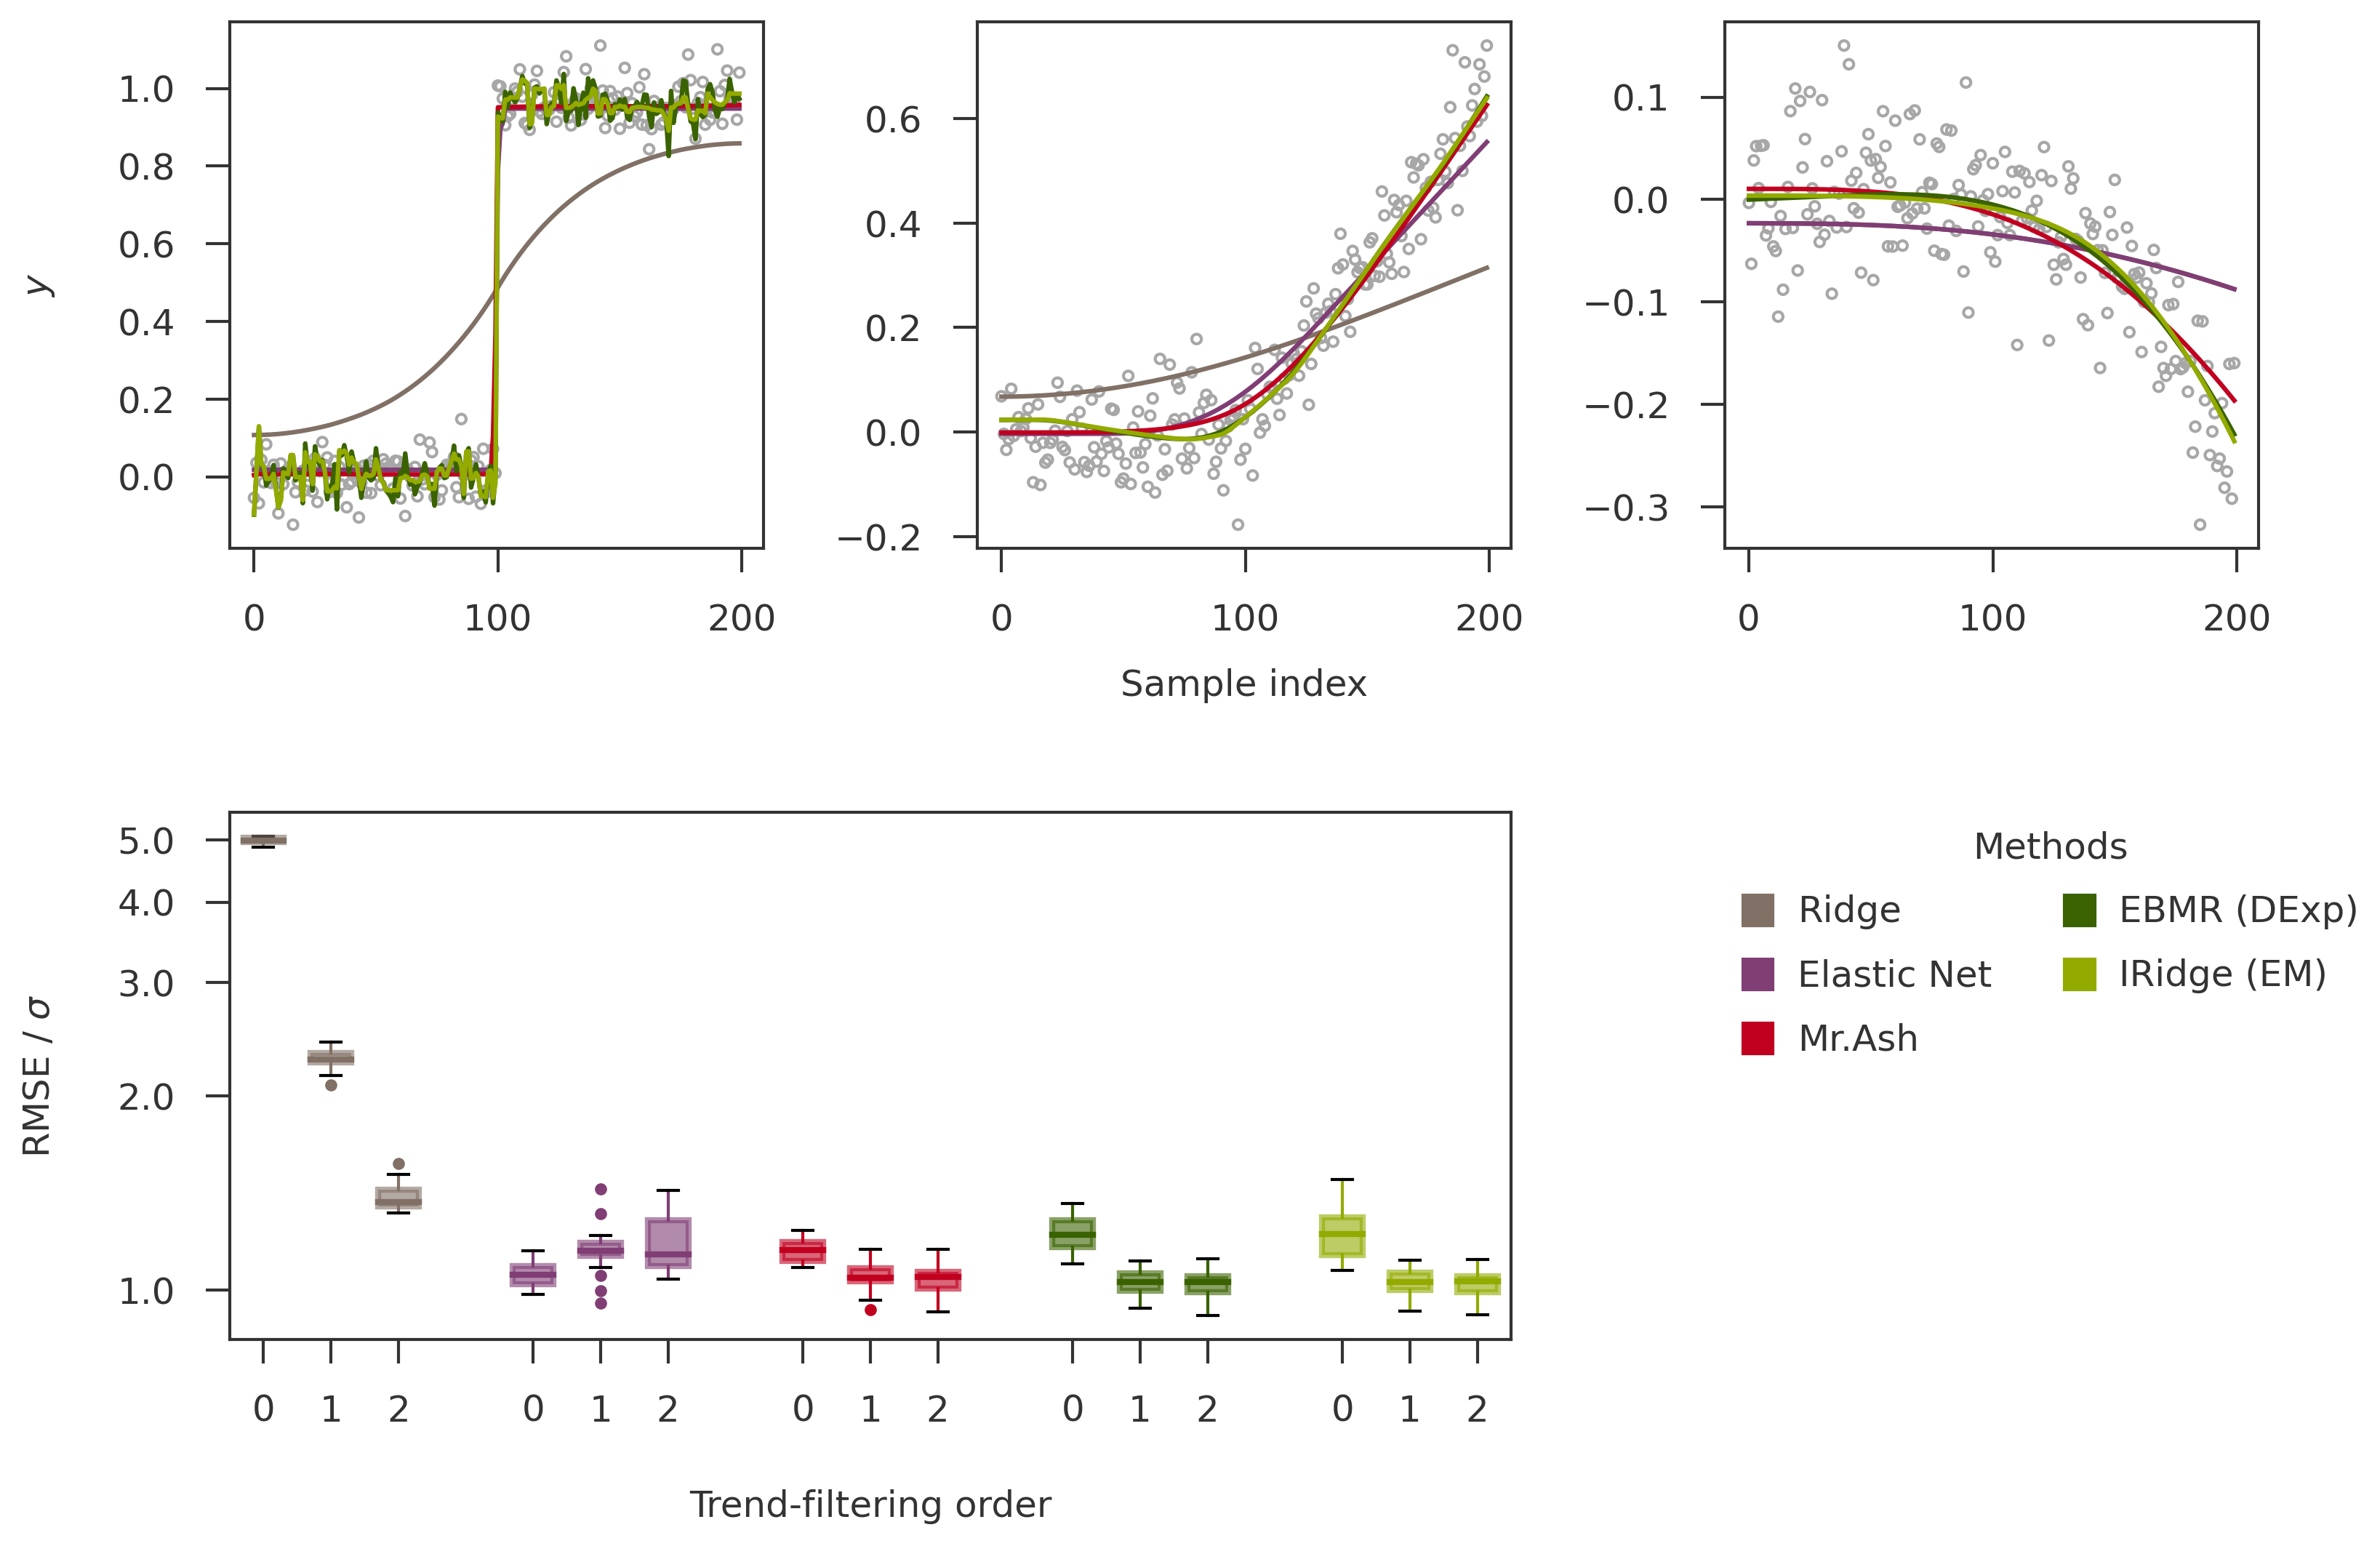

In [7]:
#collapse-hide

class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        #center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        center = xdescent, ydescent - 2.0#+ 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=height, # width = height for square
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
def get_mse_err_dsc(dscout, colname, method, orders, s = 1):
    conditions = [f"$(fit_cpt) == {method}", f"$(changepoint.sfix) == {s}"]
    mdata   = pd_utils.select_dfrows(dscout, conditions)
    mselist = list()
    for order in orders:
        mse = pd_utils.select_dfrows(mdata, [f"$(changepoint.basis_k) == {order}"])[colname].to_numpy()
        mselist.append(np.log10(mse))
    return mselist

def trend_filter_example_plot(dsc_outdir, dscout, methods, sfix, orders, plot_iter, colname = 'score1'):
    
    figw = 12
    figh = 8
    nrow = 2
    ncol = 3
    wspace = 0.4
    hspace = 0.5
    
    
    # Main plot structure
    mpl_stylesheet.banskt_presentation(splinecolor = 'black', fontsize = 12, splinewidth = 1, dpi = 300)
    fig = plt.figure(figsize = (figw, figh))
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(wspace = wspace, hspace = hspace)

    # Examples
    axlist = list()
    mhandles = list()
    mlabels = list()
    for i, order in enumerate(orders):
        ax = fig.add_subplot(gs[0, i])
        X, y, Xtest, ytest, beta, se, ypred, b0pred, b1pred \
            = dsc_extract.changepoint_predictions(dsc_outdir, methods, 
                                                  order = order, sfix = sfix, dsc_iter = plot_iter[order])
        ax.scatter(np.arange(y.shape[0]), ytest, color = '#A7A7A7', facecolor = 'None', s = 10)
        for method in methods: 
            pm = methodprops.plot_metainfo()[method]
            ax.plot(np.arange(y.shape[0]), ypred[method], color = pm.color, label = pm.label)
            if i == 0:
                mhandles.append(mpatches.Rectangle((0,0), 20, 20, **{'color': pm.color}))
                mlabels.append(pm.label)
        axlist.append(ax)

    # Square errors boxplot
    axc = fig.add_subplot(gs[1, :ncol - 1])
    norder = len(orders)
    xticks  = [j*(norder+1) + i for j in range(len(methods)) for i in range(norder)]
    xticklabels = [i for j in range(len(methods)) for i in range(norder)]
    for j, method in enumerate(methods):
        pm   = methodprops.plot_metainfo()[method]
        mse  = get_mse_err_dsc(dscout, colname, method, orders, s = sfix)
        xpos = xticks[j*norder:(j+1)*norder]
        boxprops     = dict(linewidth = 2, color = pm.color, facecolor = pm.color, alpha = 0.6)
        medianprops  = dict(linewidth = 2, color = pm.color)
        whiskerprops = dict(color = pm.color)
        flierprops   = dict(marker = 'o', markerfacecolor = pm.color, markersize=4,
                            markeredgewidth = 0, markeredgecolor = pm.color)
        boxp = axc.boxplot(mse, positions = xpos, widths = 0.6, showfliers = True, showcaps = True,
                           patch_artist = True, boxprops = boxprops, 
                           medianprops = medianprops, whiskerprops = whiskerprops, flierprops = flierprops)
    axc.set_xticks(xticks, minor = False)
    axc.set_xticklabels(xticklabels)
    mpl_utils.set_yticks(axc, scale = 'log10', kmin = 3, kmax = 4, spacing = 'linear')

    # Legend
    axl = fig.add_subplot(gs[1, ncol - 1])
    axl.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    legendtitle = 'Methods'
    mhandler_map = dict()
    for x in mhandles:
        mhandler_map[x] = HandlerSquare()
    legend1 = axl.legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map, ncol = 2,
                         loc = 'upper left', bbox_to_anchor = (0, 1.0), frameon = False, title = legendtitle)
    mpl_utils.decorate_axes(axl, hide = ["all"], ticklimits = False)

    # Axes labels
    axlist[0].set_ylabel(r"$y$")
    axlist[1].set_xlabel(r"Sample index", labelpad = 10)
    axc.set_ylabel(r"RMSE / $\sigma$")
    axc.set_xlabel("Trend-filtering order")

    plt.show()
    
plot_iter = {0: 2, 1: 4, 2: 4}
trend_filter_example_plot(dsc_outdir, dscout, methods, 1, orders, plot_iter, colname = 'score1')

### Trend-filtering with four changepoints / knots (s = 4)

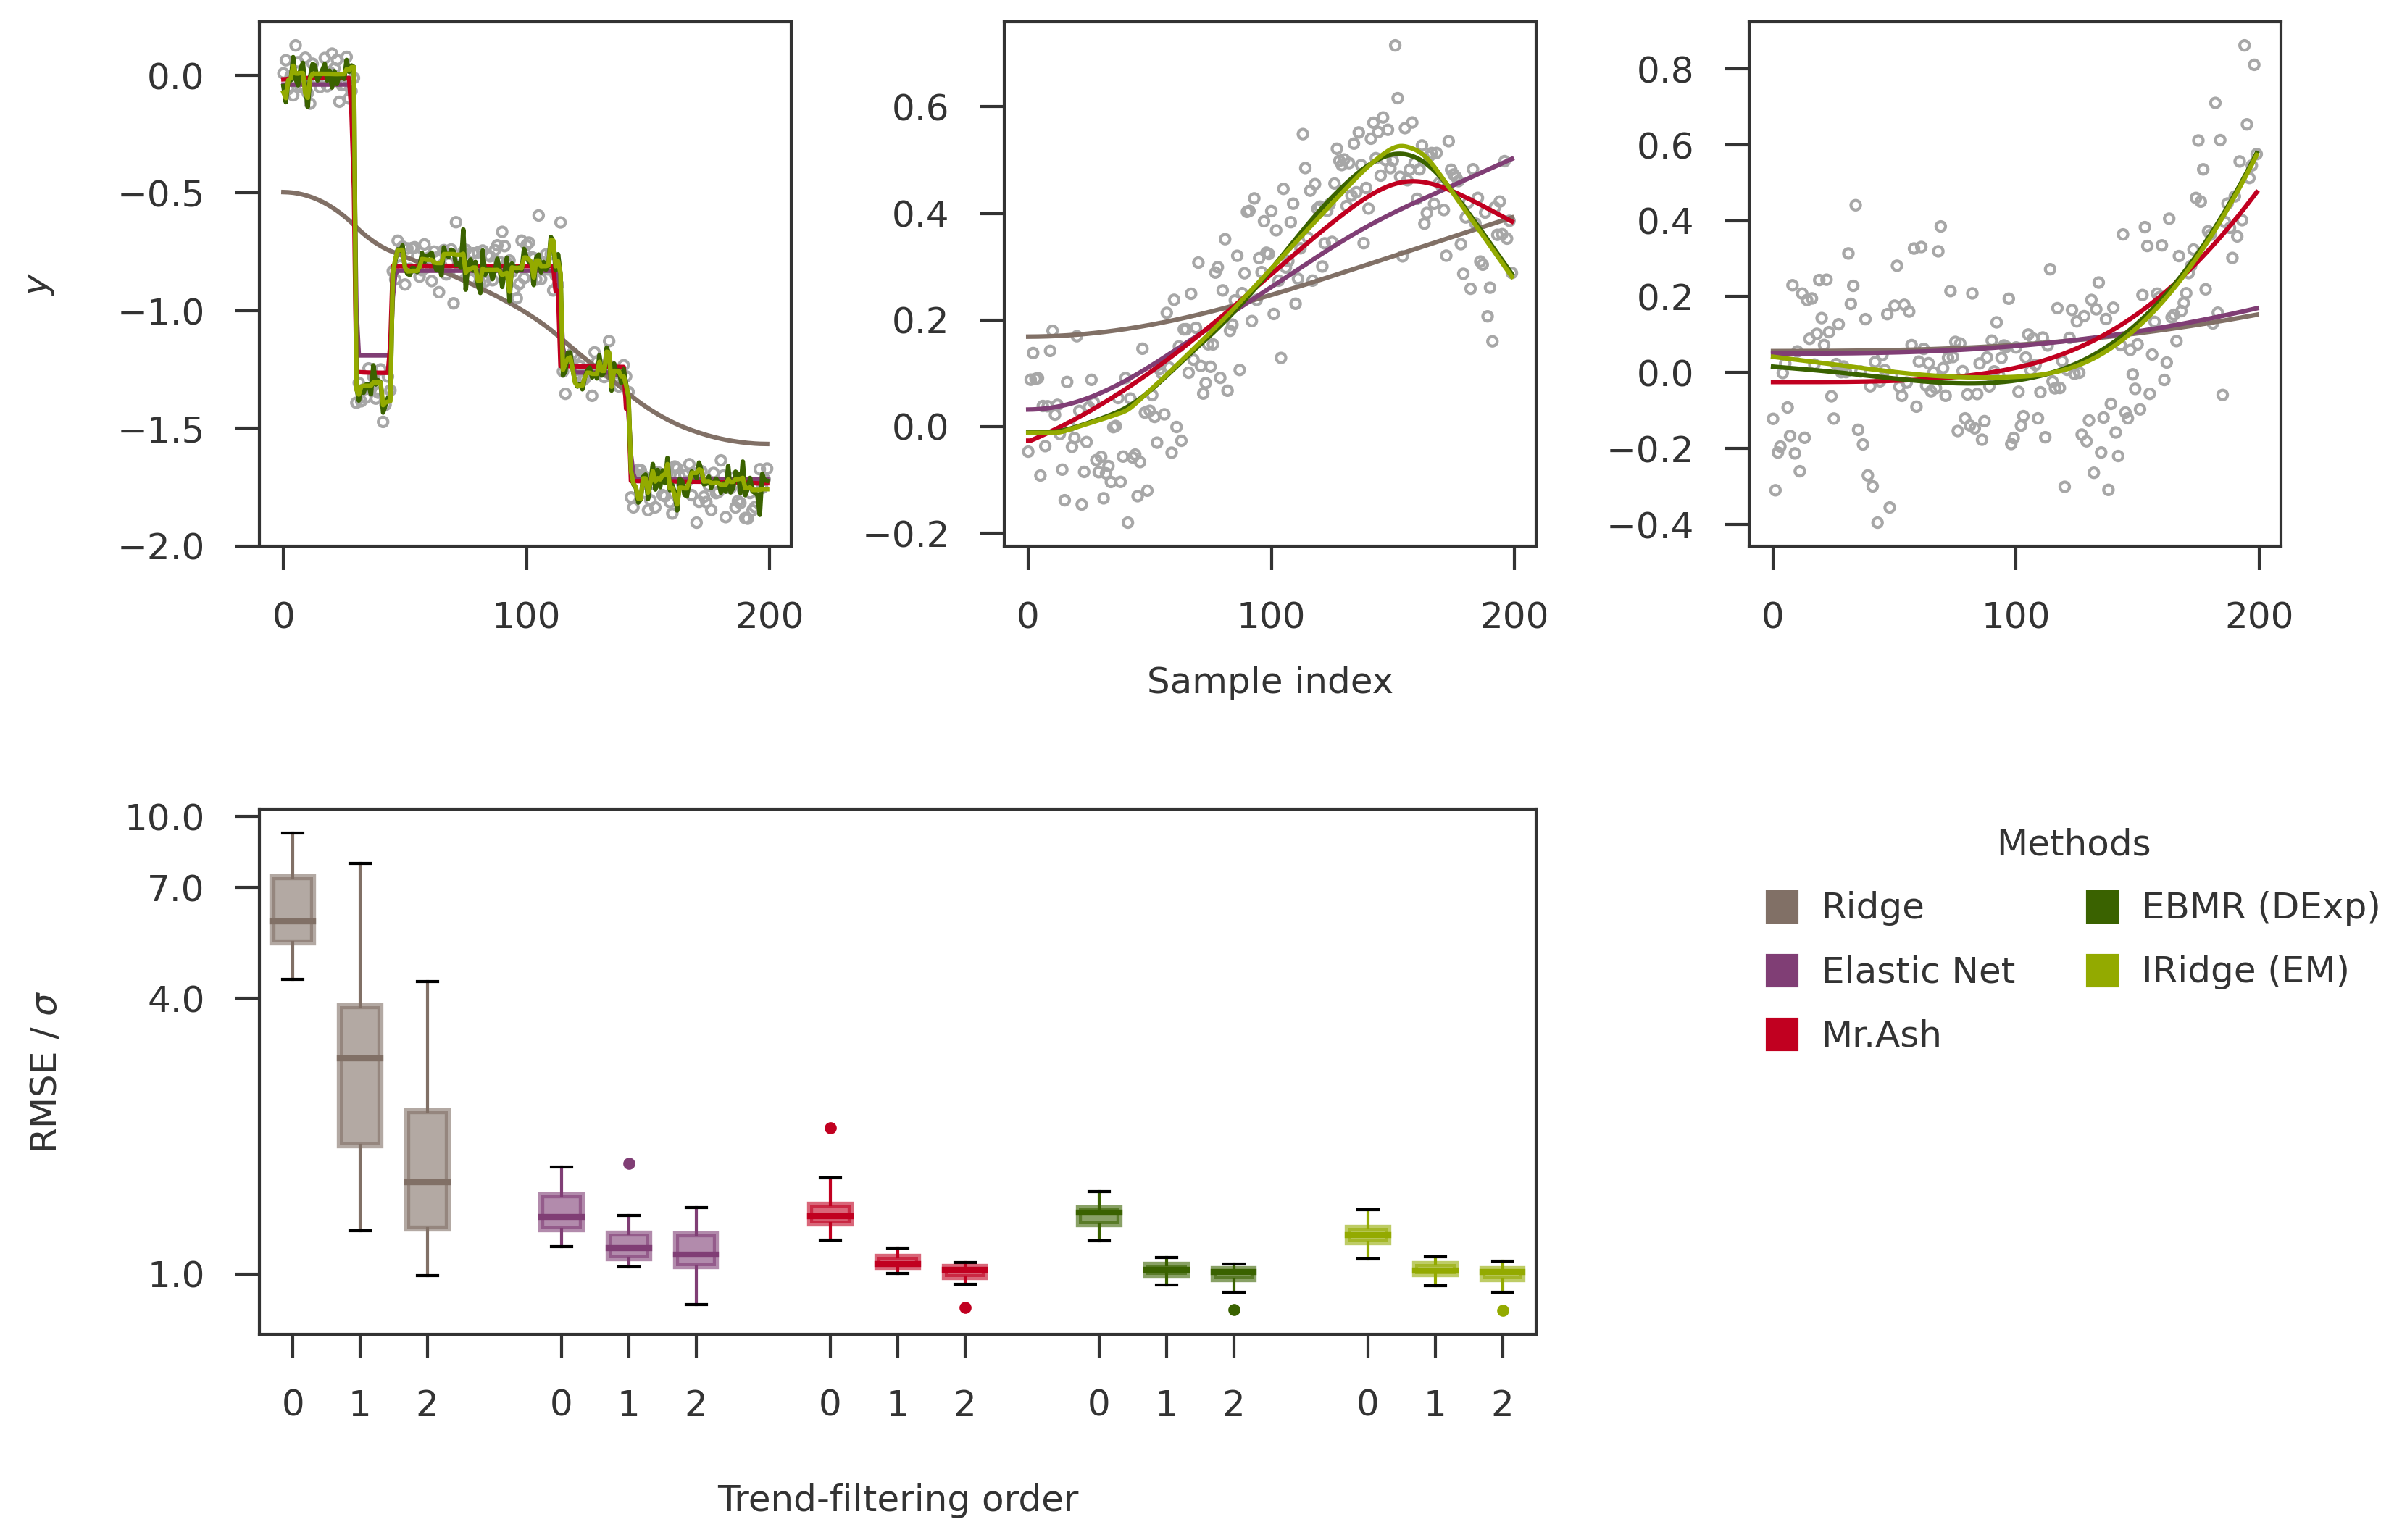

In [5]:
plot_iter = {0: 1, 1: 7, 2: 5}
trend_filter_example_plot(dsc_outdir, dscout, methods, 4, orders, plot_iter, colname = 'score1')